## cohort 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from scipy.stats import norm
import os
import warnings
warnings.filterwarnings("ignore")

######################################## mean_auc ########################################
def mean_auc(y_true_pred):
    dfs = np.array_split(y_true_pred, 5)
    roc_auc_values = []
    pr_auc_values = []

    for df in dfs:
        df = df.reset_index(drop=True)
        roc_auc_values.append(roc_auc_score(df["y_test"], df["y_pred"]))
        precision, recall, _ = precision_recall_curve(df["y_test"], df["y_pred"])
        pr_auc_values.append(auc(recall, precision))

    return round(np.mean(roc_auc_values), 3), round(np.mean(pr_auc_values), 3)


##################################### DeLong Test ########################################
def calc_auc_var(auc_val, pos, neg):
    q1 = auc_val / (2 - auc_val)
    q2 = 2 * auc_val ** 2 / (1 + auc_val)
    return (auc_val * (1 - auc_val) +
            (pos - 1) * (q1 - auc_val ** 2) +
            (neg - 1) * (q2 - auc_val ** 2)) / (pos * neg)


def delong_test(y_true, y_pred1, y_pred2):
    y_true = np.array(y_true)
    y_pred1 = np.array(y_pred1)
    y_pred2 = np.array(y_pred2)
    
    pos = y_true == 1
    neg = y_true == 0
    
    # Calculate AUC
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)
    
    pos_pred1 = y_pred1[pos]
    neg_pred1 = y_pred1[neg]
    pos_pred2 = y_pred2[pos]
    neg_pred2 = y_pred2[neg]
    
    # V10: Comparison of positive vs. negative samples
    V10_1 = np.zeros((len(pos_pred1), len(neg_pred1)))
    V10_2 = np.zeros((len(pos_pred2), len(neg_pred2)))
    
    for i in range(len(pos_pred1)):
        V10_1[i, :] = (pos_pred1[i] > neg_pred1).astype(int) + 0.5 * (pos_pred1[i] == neg_pred1)
    
    for i in range(len(pos_pred2)):
        V10_2[i, :] = (pos_pred2[i] > neg_pred2).astype(int) + 0.5 * (pos_pred2[i] == neg_pred2)
    
    # Calculate variance
    var1 = np.var(V10_1.mean(axis=1)) / len(pos_pred1) + np.var(V10_1.mean(axis=0)) / len(neg_pred1)
    var2 = np.var(V10_2.mean(axis=1)) / len(pos_pred2) + np.var(V10_2.mean(axis=0)) / len(neg_pred2)
    
    # Calculate covariance
    S10 = np.cov(V10_1.mean(axis=1), V10_2.mean(axis=1))[0, 1] / len(pos_pred1)
    S01 = np.cov(V10_1.mean(axis=0), V10_2.mean(axis=0))[0, 1] / len(neg_pred1)
    cov = S10 + S01
    
    # Calculating z-statistics
    se_diff = np.sqrt(var1 + var2 - 2 * cov)
    z = (auc1 - auc2) / se_diff if se_diff > 0 else 0
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    return auc1, auc2, z, p_value


################################### Main Loop ###########################################
models_files = ['catboost','xgboost','randomforest','DNN','LSTM','lr']
labels = ['CatBoost','XGBoost','RF','DNN','LSTM','LR']

# Read prediction results
preData = {}
for model in models_files:
    if model == 'DNN':
        file = f'/home/mailiyi/Poisoning_Prediction/{model}/predict_death_valid_test_5cv/all_folds_results.csv'
    elif model == 'LSTM':
        file = f'/home/mailiyi/Poisoning_Prediction/{model}/predict_death_valid_test_5cv/seed_1251_all_results.csv'
    elif model == 'catboost':
        file = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv'
    elif model == 'xgboost':
        file = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv'
    elif model == 'randomforest':
        file = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv/max_depth_5_n_estimators_200/all_folds_results.csv'
    elif model == 'lr':
        file = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_valid_test_5cv/all_folds_results.csv'

    preData[model] = pd.read_csv(file)

# Compute pairwise DeLong test
delong_result = pd.DataFrame()
for model1 in models_files:
    df1 = preData[model1]
    mean_auc_1, mean_pr_auc_1 = mean_auc(df1)
    for model2 in models_files:
        df2 = preData[model2]
        mean_auc_2, mean_pr_auc_2 = mean_auc(df2)

        y_true = df1['y_test']
        y_pred1 = df1['y_pred']
        y_pred2 = df2['y_pred']

        auc1, auc2, z, p_value = delong_test(y_true, y_pred1, y_pred2)

        delong_result = pd.concat([
            delong_result,
            pd.DataFrame([{
                'model_left': model1,
                'auroc_left': mean_auc_1,
                'auprc_left': mean_pr_auc_1,
                'model_right': model2,
                'auroc_right': mean_auc_2,
                'auprc_right': mean_pr_auc_2,
                'auroc_difference': round(mean_auc_1 - mean_auc_2, 3),
                'auprc_difference': round(mean_pr_auc_1 - mean_pr_auc_2, 3),
                'z': z,
                'p_value': p_value
            }])
        ], ignore_index=True)

save_path = '/home/mailiyi/Poisoning_Prediction/prediction_plot/delong_test/death/'
os.makedirs(save_path, exist_ok=True)
delong_result.to_csv(os.path.join(save_path, 'models_delong_test.csv'), index=False)


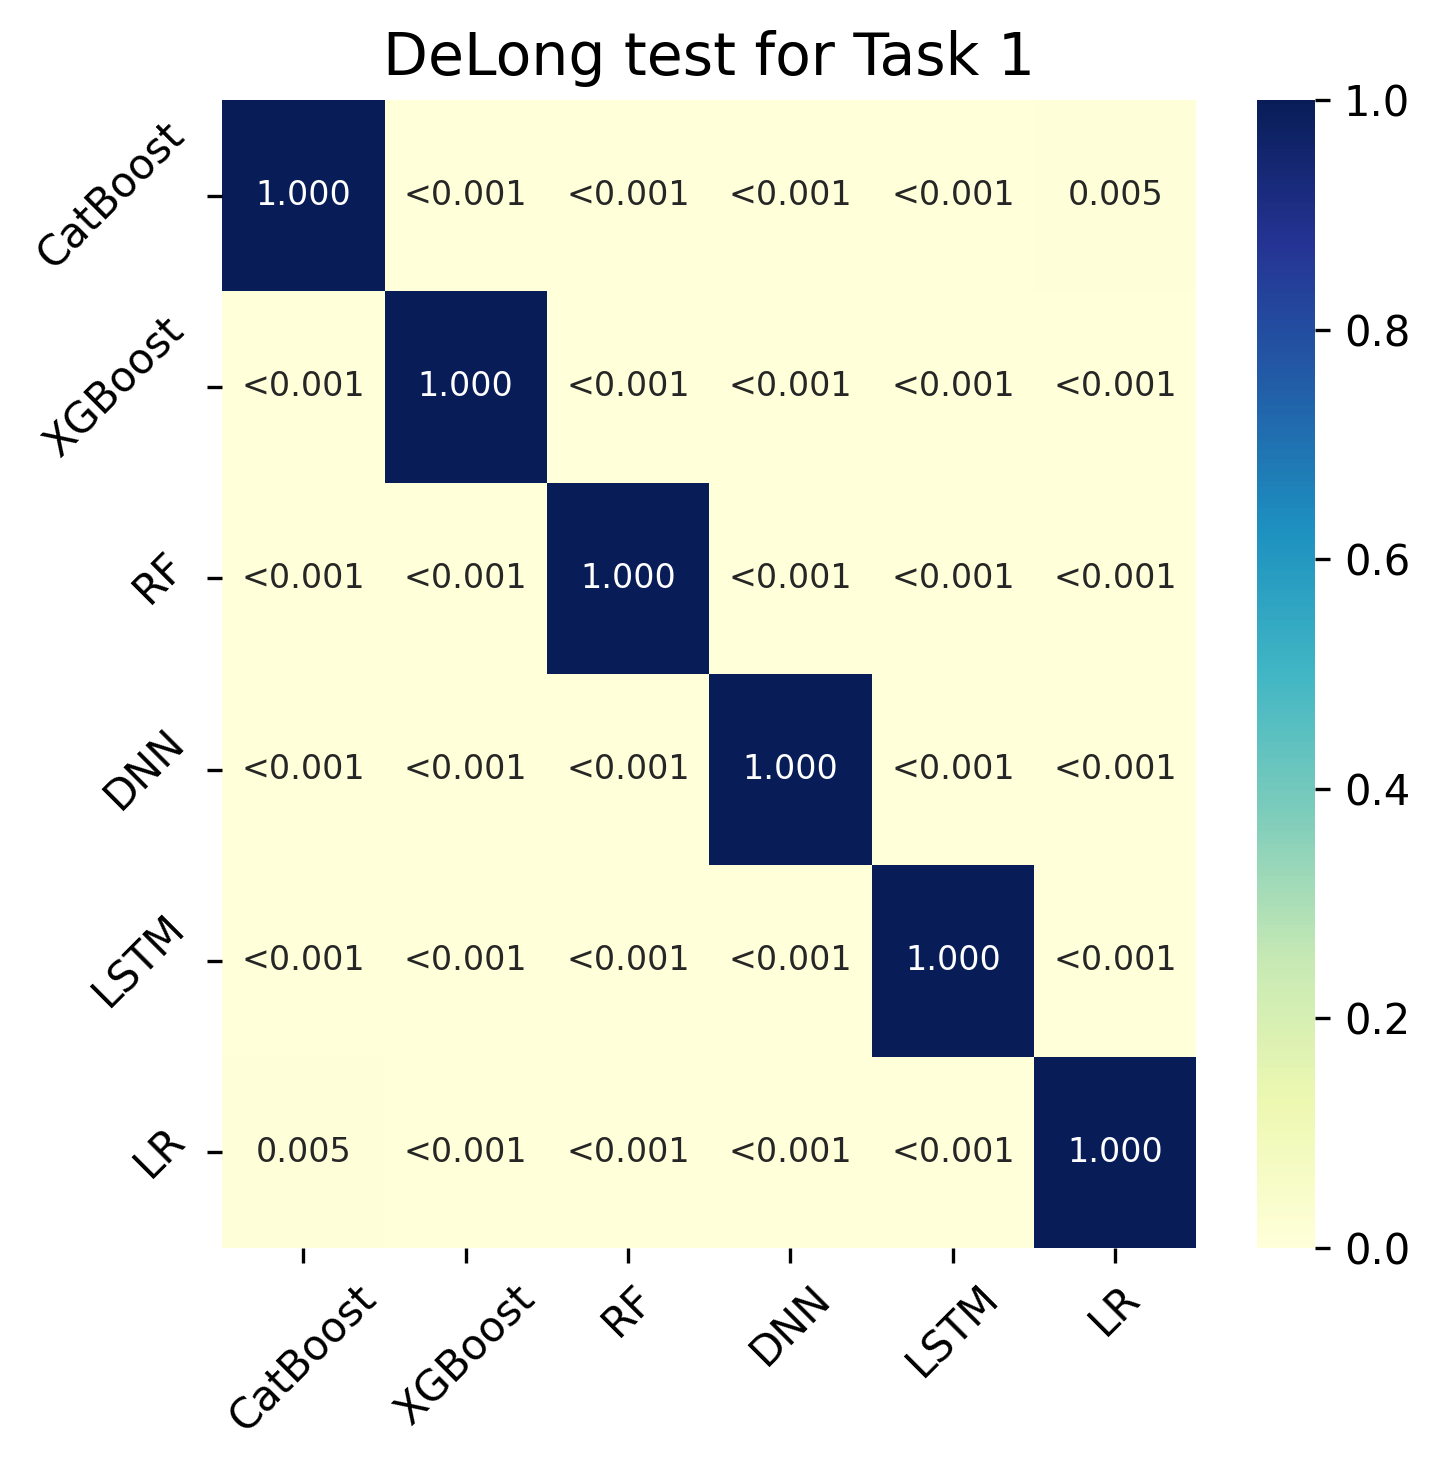

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

save_path = '/home/mailiyi/Poisoning_Prediction/prediction_plot/delong_test/death/'
delong_result = pd.read_csv(os.path.join(save_path, 'models_delong_test.csv'))

models_files = ['catboost','xgboost','randomforest','DNN','LSTM','lr']
labels = ['CatBoost','XGBoost','RF','DNN','LSTM','LR']

delong_result['p_value'] = pd.to_numeric(delong_result['p_value'], errors='coerce')
delong_result['z'] = pd.to_numeric(delong_result['z'], errors='coerce')

list_2d_pvalue = []
list_2d_z = []

for model1 in models_files:
    temp = delong_result[delong_result['model_left'] == model1]
    temp_p = []
    temp_z = []
    for model2 in models_files:
        val = temp[temp['model_right'] == model2]['p_value'].values[0]
        z_val = temp[temp['model_right'] == model2]['z'].values[0]
        temp_p.append(val)
        temp_z.append(z_val)
    list_2d_pvalue.append(temp_p)
    list_2d_z.append(temp_z)

p_values = np.array(list_2d_pvalue)
z_matrix = np.array(list_2d_z)

text_matrix = np.empty(p_values.shape, dtype=object)
for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        if p_values[i, j] < 0.001:
            text_matrix[i, j] = "<0.001"
        else:
            text_matrix[i, j] = f"{p_values[i, j]:.3f}"

# Heat mapping
plt.figure(figsize=(5,5), dpi=300)
sns.heatmap(p_values, annot=text_matrix, fmt='', cmap="YlGnBu",
            xticklabels=labels,
            yticklabels=labels,
            annot_kws={"size": 8})

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('DeLong test for Task 1', fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(save_path, 'delong_pvalue_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()


#### Cohort 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from scipy.stats import norm
import os
import warnings
warnings.filterwarnings("ignore")

######################################## mean_auc ########################################
def mean_auc(y_true_pred):
    dfs = np.array_split(y_true_pred, 5)
    roc_auc_values = []
    pr_auc_values = []

    for df in dfs:
        df = df.reset_index(drop=True)
        roc_auc_values.append(roc_auc_score(df["y_test"], df["y_pred"]))
        precision, recall, _ = precision_recall_curve(df["y_test"], df["y_pred"])
        pr_auc_values.append(auc(recall, precision))

    return round(np.mean(roc_auc_values), 3), round(np.mean(pr_auc_values), 3)


##################################### DeLong Test ########################################
def calc_auc_var(auc_val, pos, neg):
    q1 = auc_val / (2 - auc_val)
    q2 = 2 * auc_val ** 2 / (1 + auc_val)
    return (auc_val * (1 - auc_val) +
            (pos - 1) * (q1 - auc_val ** 2) +
            (neg - 1) * (q2 - auc_val ** 2)) / (pos * neg)

def delong_test(y_true, y_pred1, y_pred2):
    y_true = np.array(y_true)
    y_pred1 = np.array(y_pred1)
    y_pred2 = np.array(y_pred2)
    
    pos = y_true == 1
    neg = y_true == 0
    
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)
    
    pos_pred1 = y_pred1[pos]
    neg_pred1 = y_pred1[neg]
    pos_pred2 = y_pred2[pos]
    neg_pred2 = y_pred2[neg]
    
    V10_1 = np.zeros((len(pos_pred1), len(neg_pred1)))
    V10_2 = np.zeros((len(pos_pred2), len(neg_pred2)))
    
    for i in range(len(pos_pred1)):
        V10_1[i, :] = (pos_pred1[i] > neg_pred1).astype(int) + 0.5 * (pos_pred1[i] == neg_pred1)
    
    for i in range(len(pos_pred2)):
        V10_2[i, :] = (pos_pred2[i] > neg_pred2).astype(int) + 0.5 * (pos_pred2[i] == neg_pred2)
    
    var1 = np.var(V10_1.mean(axis=1)) / len(pos_pred1) + np.var(V10_1.mean(axis=0)) / len(neg_pred1)
    var2 = np.var(V10_2.mean(axis=1)) / len(pos_pred2) + np.var(V10_2.mean(axis=0)) / len(neg_pred2)
    
    S10 = np.cov(V10_1.mean(axis=1), V10_2.mean(axis=1))[0, 1] / len(pos_pred1)
    S01 = np.cov(V10_1.mean(axis=0), V10_2.mean(axis=0))[0, 1] / len(neg_pred1)
    cov = S10 + S01
    
    se_diff = np.sqrt(var1 + var2 - 2 * cov)
    z = (auc1 - auc2) / se_diff if se_diff > 0 else 0
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    return auc1, auc2, z, p_value


################################### Main Loop ###########################################

models_files = ['catboost','xgboost','randomforest','DNN','LSTM','lr']
labels = ['CatBoost','XGBoost','RF','DNN','LSTM','LR']

# Read prediction results
preData = {}
for model in models_files:
    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv','seed_5628', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv', 'seed_7567','seed_7567_all_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## 训练模型时试随机种子
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## 训练模型时试随机种子
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')

    preData[model] = pd.read_csv(file)

# Compute pairwise DeLong test
delong_result = pd.DataFrame()
for model1 in models_files:
    df1 = preData[model1]
    mean_auc_1, mean_pr_auc_1 = mean_auc(df1)
    for model2 in models_files:
        df2 = preData[model2]
        mean_auc_2, mean_pr_auc_2 = mean_auc(df2)

        y_true = df1['y_test']
        y_pred1 = df1['y_pred']
        y_pred2 = df2['y_pred']

        auc1, auc2, z, p_value = delong_test(y_true, y_pred1, y_pred2)

        delong_result = pd.concat([
            delong_result,
            pd.DataFrame([{
                'model_left': model1,
                'auroc_left': mean_auc_1,
                'auprc_left': mean_pr_auc_1,
                'model_right': model2,
                'auroc_right': mean_auc_2,
                'auprc_right': mean_pr_auc_2,
                'auroc_difference': round(mean_auc_1 - mean_auc_2, 3),
                'auprc_difference': round(mean_pr_auc_1 - mean_pr_auc_2, 3),
                'z': z,
                'p_value': p_value
            }])
        ], ignore_index=True)

save_path = '/home/mailiyi/Poisoning_Prediction/prediction_plot/delong_test/non-recovery/'
os.makedirs(save_path, exist_ok=True)
delong_result.to_csv(os.path.join(save_path, 'models_delong_test.csv'), index=False)


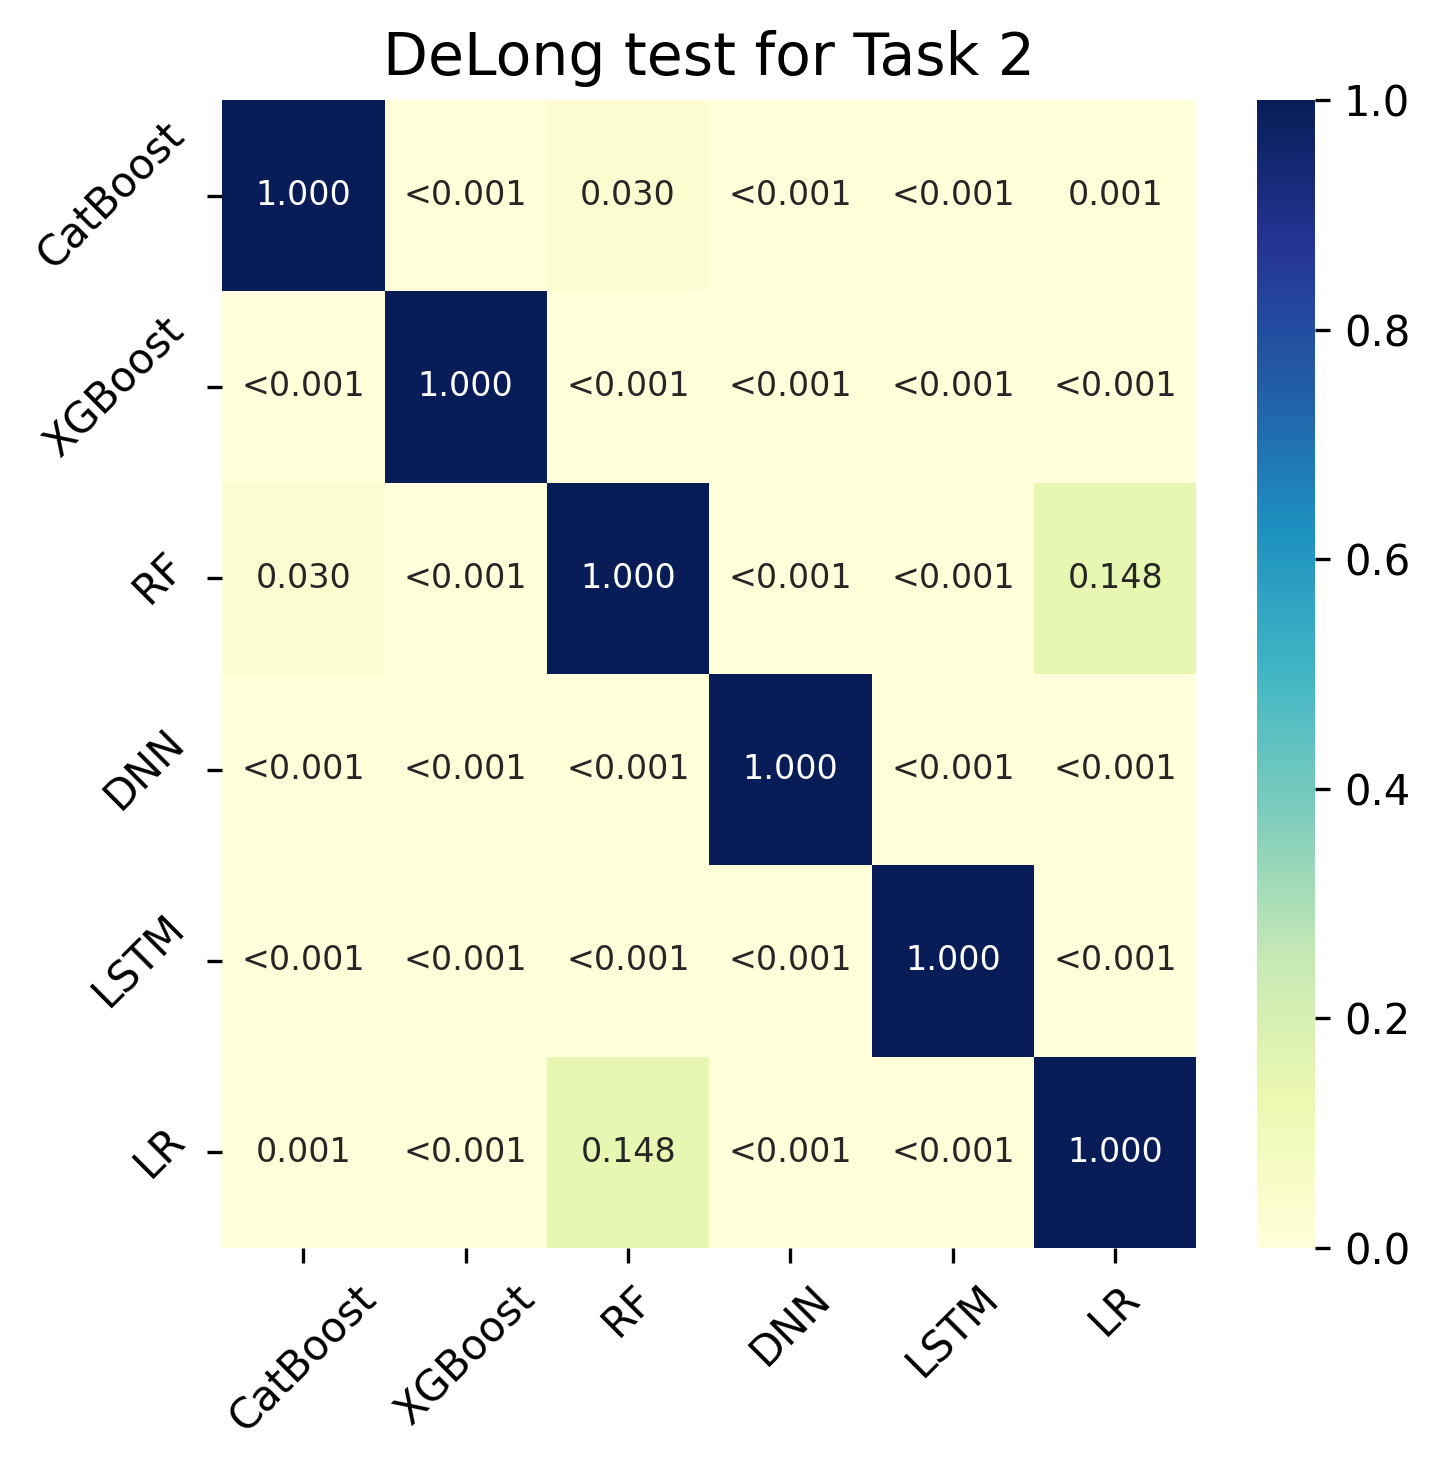

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

save_path = '/home/mailiyi/Poisoning_Prediction/prediction_plot/delong_test/non-recovery/'
delong_result = pd.read_csv(os.path.join(save_path, 'models_delong_test.csv'))

models_files = ['catboost','xgboost','randomforest','DNN','LSTM','lr']
labels = ['CatBoost','XGBoost','RF','DNN','LSTM','LR']

delong_result['p_value'] = pd.to_numeric(delong_result['p_value'], errors='coerce')
delong_result['z'] = pd.to_numeric(delong_result['z'], errors='coerce')

list_2d_pvalue = []
list_2d_z = []

for model1 in models_files:
    temp = delong_result[delong_result['model_left'] == model1]
    temp_p = []
    temp_z = []
    for model2 in models_files:
        val = temp[temp['model_right'] == model2]['p_value'].values[0]
        z_val = temp[temp['model_right'] == model2]['z'].values[0]
        temp_p.append(val)
        temp_z.append(z_val)
    list_2d_pvalue.append(temp_p)
    list_2d_z.append(temp_z)

p_values = np.array(list_2d_pvalue)
z_matrix = np.array(list_2d_z)

text_matrix = np.empty(p_values.shape, dtype=object)
for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        if p_values[i, j] < 0.001:
            text_matrix[i, j] = "<0.001"
        else:
            text_matrix[i, j] = f"{p_values[i, j]:.3f}"

# Heat mapping
plt.figure(figsize=(5,5), dpi=300)
sns.heatmap(p_values, annot=text_matrix, fmt='', cmap="YlGnBu",
            xticklabels=labels,
            yticklabels=labels,
            annot_kws={"size": 8})

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('DeLong test for Task 2', fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(save_path, 'delong_pvalue_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
